In [1]:
%%time
import os
import numpy as np
import gradio as gr
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
start_time = datetime.now()

CPU times: total: 4.59 s
Wall time: 9.11 s


In [2]:
%%time
# Definir la ruta al directorio actual y al directorio de entrenamiento
directorio_actual = os.getcwd()
train_dir = os.path.join(directorio_actual, 'TRAIN.1')
test_dir = os.path.join(directorio_actual, 'TEST')
print(train_dir)
print(test_dir)

C:\Users\Usuario\Desktop\Mis notebooks\TFM\TRAIN.1
C:\Users\Usuario\Desktop\Mis notebooks\TFM\TEST
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time
# Configurar el preprocesamiento de imágenes
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización de las imágenes
    rotation_range=20,  # Reducir el rango de rotación para evitar distorsiones fuertes
    width_shift_range=0.1,  # Reducir para evitar distorsiones fuertes
    height_shift_range=0.1,  # Reducir para evitar distorsiones fuertes
    shear_range=10,  # Reducir para evitar distorsiones fuertes
    zoom_range=0.8,  # Rango de zoom menos agresivo
    horizontal_flip=True,
    vertical_flip=True,
)

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
# Generadores de datos
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['B', 'N']
)

validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['B', 'N']
)

# Construcción del modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), # Ajustar si es necesario, por ejemplo, a 0.4 o 0.6 para ver si mejora el rendimiento
    Dense(1, activation='sigmoid')
])

learning_rate = 0.001  # Cambia la tasa de aprendizaje según tus necesidades

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
CPU times: total: 1.39 s
Wall time: 776 ms


In [5]:
%%time
# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks para evitar el sobreentrenamiento y ajustar la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Paciencia reducida para detenerse más pronto
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)  # Valor mínimo de LR reducido

CPU times: total: 0 ns
Wall time: 11 ms


In [6]:
%%time
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=30,  # Reducido el número de épocas para observar el efecto de los callbacks
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8428

C:\Users\Usuario\anaconda3\envs\Python_3115_project\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 411s 2s/step - loss: 0.4488 - accuracy: 0.8428 - val_loss: 0.8134 - val_accuracy: 0.5505 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - 408s 2s/step - loss: 0.3416 - accuracy: 0.8619 - val_loss: 0.6421 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 3/30
250/250 [==============================] - 410s 2s/step - loss: 0.3255 - accuracy: 0.8594 - val_loss: 1.1374 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
250/250 [==============================] - 408s 2s/step - loss: 0.3075 - accuracy: 0.8710 - val_loss: 0.4740 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 5/30
250/250 [==============================] - 407s 2s/step - loss: 0.2939 - accuracy: 0.8767 - val_loss: 0.4140 - val_accuracy: 0.8165 - lr: 0.0010
Epoch 6/30
250/250 [==============================] - 405s 2s/step - loss: 0.2981 - accuracy: 0.8759 - val_loss: 0.3821 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 7/30
250/250 [==============================] - 399s 2s/step - loss: 

In [7]:
%%time
# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 [==============================] - 32s 501ms/step - loss: 0.3993 - accuracy: 0.8265
Test Accuracy: 0.8265
CPU times: total: 3min 10s
Wall time: 32.1 s


Tiempo de ejecución total: 81 minutos y 35 segundos
CPU times: total: 266 ms
Wall time: 3.83 s


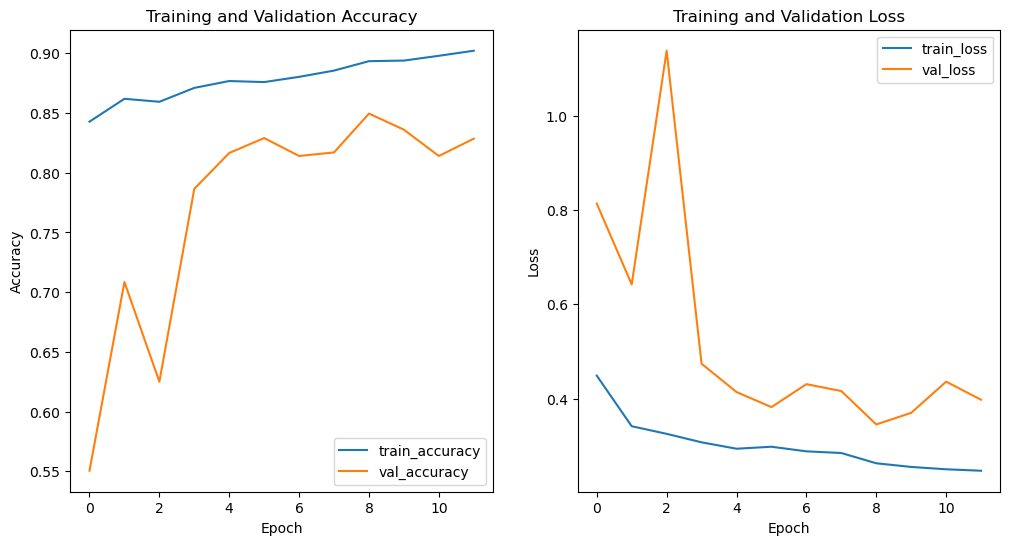

In [8]:
%%time
# Graficar la precisión y la pérdida a lo largo de las épocas

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Guardar la gráfica como imagen
plt.savefig('training_performance.png')

# Mostrar la gráfica
img = Image.open('training_performance.png')
img.show()
end_time = datetime.now()
time_diff = end_time - start_time
minutes = time_diff.seconds // 60
seconds = time_diff.seconds % 60
print(f"Tiempo de ejecución total: {minutes} minutos y {seconds} segundos")

In [10]:
# Guardar el modelo en formato HDF5
model.save('mi_modelo.h5')
# O guardar el modelo como un TensorFlow SavedModel
model.save('mi_modelo_saved_model')

C:\Users\Usuario\anaconda3\envs\Python_3115_project\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: mi_modelo_saved_model\assets


INFO:tensorflow:Assets written to: mi_modelo_saved_model\assets


In [9]:
%%time
# Definir funciones de procesamiento de imágenes y resultados para Gradio

def process_image_and_predict(img):
    img_resized = image.img_to_array(img)
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = tf.image.resize(img_resized, (256,256))
    img_array = img_resized / 255.0  # Normalizar
    prediction = model.predict(img_array)
    if prediction[0][0] >= 0.5:
        label = "No Biodegradable"
    else:
        label = "Biodegradable"
    confidence = float(prediction[0][0])
    return label, confidence

def mostrar_resultado(input_image):
    label, confidence = process_image_and_predict(input_image)
    return f"Prediction: {label} (Confidence: {confidence:.4f})"

# Integración con Gradio
iface = gr.Interface(
    fn=mostrar_resultado,
    inputs="image",
    outputs="label",
    title="¿Biodegradable o No?",
    description="¡Suba una imagen para identificar si es biodegradable o no!"
)

iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


CPU times: total: 141 ms
Wall time: 133 ms
